In [1]:
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
import PIL
import zipfile
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [2]:
!unzip '/content/UTKFace_Images.zip'

Archive:  /content/UTKFace_Images.zip
  inflating: UTKface_inthewild/part1.tar.gz  
  inflating: UTKface_inthewild/part3.tar.gz  
  inflating: UTKface_inthewild/part2.tar.gz  


In [3]:
# Create base folder "faces" to store image set
# If folder does not exist, then create it
if not os.path.exists('/content/faces'):
    os.makedirs('/content/faces')

In [4]:
# Extract .jpg images from base UTKface_inthewild to destination folder (faces)
!tar -xzvf "/content/UTKface_inthewild/part1.tar.gz" -C "/content/faces/"

Streaming output truncated to the last 5000 lines.
part1/14_0_2_20170103201051263.jpg
part1/30_1_0_20170104170158777.jpg
part1/62_0_0_20170104212928133.jpg
part1/27_1_0_20170103230354912.jpg
part1/65_1_0_20170110123252108.jpg
part1/60_1_0_20170110151441645.jpg
part1/44_1_3_20170109141426511.jpg
part1/62_0_3_20170104220837477.jpg
part1/25_1_0_20170111182452788.jpg
part1/10_1_0_20170109204244904.jpg
part1/27_1_0_20170105183939496.jpg
part1/1_0_2_20161219212557190.jpg
part1/9_0_0_20170110221659430.jpg
part1/67_1_0_20170110140730634.jpg
part1/62_1_0_20170110160643751.jpg
part1/1_1_3_20161220220534186.jpg
part1/39_0_2_20170104204400674.jpg
part1/27_1_3_20170104223400455.jpg
part1/37_0_4_20170104000748917.jpg
part1/2_0_2_20161219162357438.jpg
part1/2_0_2_20161219222714623.jpg
part1/52_0_2_20170104184356222.jpg
part1/60_1_0_20170110122626700.jpg
part1/32_1_0_20170103181503793.jpg
part1/41_0_0_20170109012220690.jpg
part1/1_0_4_20161221201411850.jpg
part1/60_0_0_20170111203255875.jpg
part1/1_1_

In [5]:
# Declare the base directory where image data is held
# Create empty lists to hold data
base_dir = '/content/faces/part1'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(base_dir)
random.shuffle(image_filenames)

# Test print, ensure file names are present and in correct format
# print(image_filenames)

# Extract image component features (gender is index 0, age is index 1)
for image in tqdm(image_filenames):
    image_path = os.path.join(base_dir, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

    # Append image_path, age label, and gender label
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

['42_1_3_20170104220806510.jpg', '5_1_4_20161223230128667.jpg', '62_1_0_20170110160643813.jpg', '16_0_0_20170104012305505.jpg', '42_0_4_20170104185534278.jpg', '80_1_0_20170110141751087.jpg', '8_0_0_20170110215948795.jpg', '18_0_0_20170110231723682.jpg', '80_0_2_20170111205702505.jpg', '23_1_3_20170105002606965.jpg', '54_0_0_20170105170040476.jpg', '2_0_3_20161220143054648.jpg', '61_1_3_20170109142555460.jpg', '56_0_0_20170111203052213.jpg', '60_1_0_20170110131536983.jpg', '1_0_4_20170103202412648.jpg', '24_1_2_20170109213251114.jpg', '1_1_2_20161219153256492.jpg', '31_1_3_20170104223530512.jpg', '1_0_0_20170110212624891.jpg', '56_1_0_20170110154644528.jpg', '35_1_3_20170109135835957.jpg', '41_0_2_20170105164126307.jpg', '58_0_0_20170111205913082.jpg', '67_1_0_20170109150548754.jpg', '2_0_2_20161219152914700.jpg', '17_0_0_20170110231719325.jpg', '46_1_1_20170111182452917.jpg', '4_0_2_20161219194148499.jpg', '4_0_0_20170110224617729.jpg', '24_1_4_20170104005530664.jpg', '14_1_0_20170109

  0%|          | 0/10137 [00:00<?, ?it/s]

In [6]:
# Test print, ensure data length consistent across all extracted image features
# Should be 10137 age labels, gender labels, and image paths
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 10137, Number of gender_labels: 10137, Number of image_paths: 10137


In [7]:
# Designate gender mapping for ease of use
gender_mapping = {1: 'Female', 0: 'Male'}

In [8]:
# Establish DataFrame, show first 5 data collections
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/faces/part1/42_1_3_20170104220806510.jpg,42,1
1,/content/faces/part1/5_1_4_20161223230128667.jpg,5,1
2,/content/faces/part1/62_1_0_20170110160643813.jpg,62,1
3,/content/faces/part1/16_0_0_20170104012305505.jpg,16,0
4,/content/faces/part1/42_0_4_20170104185534278.jpg,42,0


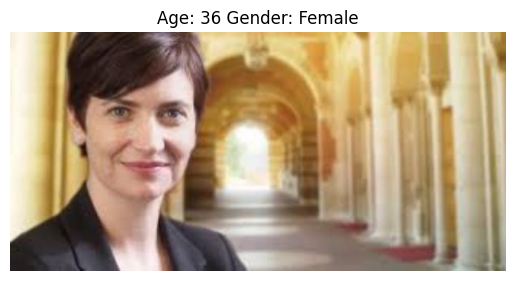

In [9]:
from PIL import Image

# Create random index to pull image from collection
rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
# Open image and title it using associated Age/Gender data
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

In [10]:
# Display collection of test images
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index+1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
def extract_image_features(images):
  features = list()

  for image in tqdm(images):
    img = load_img(image, grayscale=True)
    #img = img.resize((128, 128), Image.ANTIALIAS)
    img = img.resize((128, 128), PIL.Image.LANCZOS)
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  features = features.reshape(len(features), 128, 128, 1)

  return features

In [12]:
X = extract_image_features(df['image_path'])

  0%|          | 0/10137 [00:00<?, ?it/s]

In [13]:
# Verify the shape of X (target = 10137, 128, 128, 1)
X.shape

(10137, 128, 128, 1)

In [14]:
# Normalize each image
X = X / 255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)

In [17]:
inputs = Input((input_shape))
conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
max1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(max1)
max2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(max2)
max3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu')(max3)
max4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(max4)

# Fully Connected Layers
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(256, activation='relu')(flatten)

dropout1 = Dropout(0.3)(dense1)
dropout2 = Dropout(0.3)(dense2)

output1 = Dense(1, activation='sigmoid', name='gender_out')(dropout1)
output2 = Dense(1, activation='relu', name='age_out')(dropout2)

model = Model(inputs=[inputs], outputs=[output1, output2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

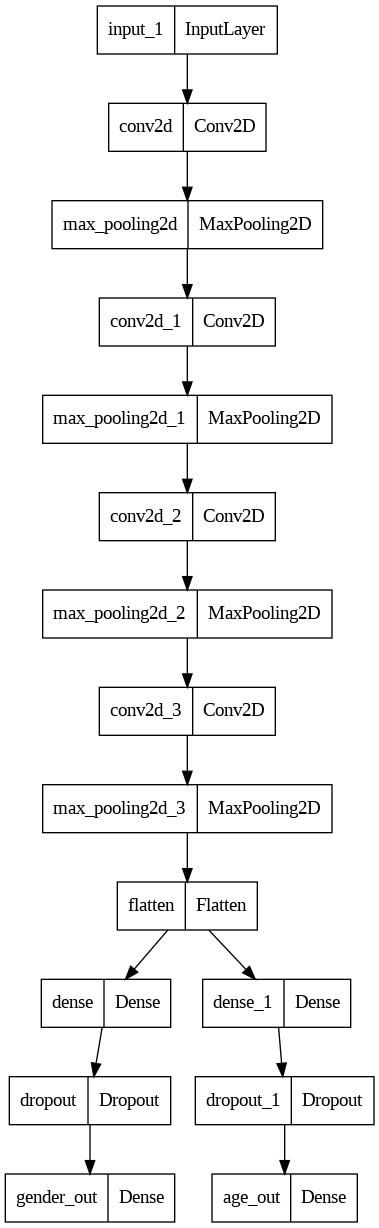

In [18]:
# Plot Model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
254/254 [==============================] - 355s 1s/step - loss: 20.3788 - gender_out_loss: 0.6875 - age_out_loss: 19.6913 - gender_out_accuracy: 0.5609 - age_out_accuracy: 0.1284 - val_loss: 19.1178 - val_gender_out_loss: 0.6664 - val_age_out_loss: 18.4514 - val_gender_out_accuracy: 0.5784 - val_age_out_accuracy: 0.1129
Epoch 2/20
254/254 [==============================] - 342s 1s/step - loss: 18.9347 - gender_out_loss: 0.6663 - age_out_loss: 18.2684 - gender_out_accuracy: 0.5877 - age_out_accuracy: 0.1274 - val_loss: 18.3254 - val_gender_out_loss: 0.6602 - val_age_out_loss: 17.6651 - val_gender_out_accuracy: 0.5937 - val_age_out_accuracy: 0.1129
Epoch 3/20
254/254 [==============================] - 291s 1s/step - loss: 17.9736 - gender_out_loss: 0.6543 - age_out_loss: 17.3193 - gender_out_accuracy: 0.6144 - age_out_accuracy: 0.1258 - val_loss: 17.6800 - val_gender_out_loss: 0.6459 - val_age_out_loss: 17.0341 - val_gender_out_accuracy: 0.6105 - val_age_out_accuracy: 0.1114
E

In [21]:
def get_img_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), PIL.Image.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0

  return img

In [22]:
# Create test image folder "testing"
# If folder does not exist, then create it
if not os.path.exists('/content/TestImages'):
    os.makedirs('/content/TestImages')

1/1 [==============================] - 0s 51ms/step


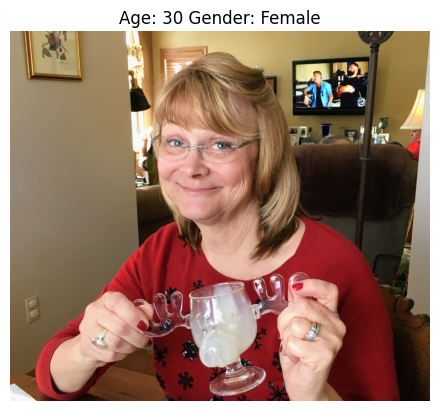

In [32]:
test_image = '/content/TestImages/img2.JPG'

features = get_img_features(test_image)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Age: {age} Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(test_image)))